<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Pre_trained_Image_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title EarlyStopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [ ]:
!git clone https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models
!pip install -r requirements.txt -q
!python setup.py install -q
%cd ..

import os
os.kill(os.getpid(), 9)
# Restart Runtime

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 992, done.
remote: Counting objects: 100% (992/992), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 5794 (delta 738), reused 928 (delta 715), pack-reused 4802
Receiving objects: 100% (5794/5794), 16.87 MiB | 11.47 MiB/s, done.
Resolving deltas: 100% (4215/4215), done.
/content/pytorch-image-models
running install
running bdist_egg
running egg_info
creating timm.egg-info
writing timm.egg-info/PKG-INFO
writing dependency_links to timm.egg-info/dependency_links.txt
writing requirements to timm.egg-info/requires.txt
writing top-level names to timm.egg-info/top_level.txt
writing manifest file 'timm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'timm.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/timm
copying timm/version.py -> build/lib/timm
co

In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
!7z x /content/Train.7z

--2021-03-17 06:36:00--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20653102 (20M) [application/octet-stream]
Saving to: ‘Train.7z’

Train.7z            100%[===================>]  19.70M  75.3MB/s    in 0.3s    

2021-03-17 06:36:01 (75.3 MB/s) - ‘Train.7z’ saved [20653102/20653102]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 20653102 bytes (20 MiB)

Extracting archive: /content/Train.7z
--
Path = /content/Train.7z
Ty

In [3]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
!7z x /content/Val.7z

--2021-03-17 06:36:02--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6662034 (6.4M) [application/octet-stream]
Saving to: ‘Val.7z’

Val.7z              100%[===================>]   6.35M  --.-KB/s    in 0.1s    

2021-03-17 06:36:03 (54.5 MB/s) - ‘Val.7z’ saved [6662034/6662034]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 6662034 bytes (6506 KiB)

Extracting archive: /content/Val.7z
--
Path = /content/Val.7z
Type = 7z
Phy

In [4]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms

## Cleaning and getting a final data

In [ ]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.csv' not in x]

In [ ]:
data = pd.read_excel("/content/Dataset/all_meta_data.xlsx")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [ ]:
data = pd.read_csv('/content/parasites.csv')

In [ ]:
data['species'].value_counts()

Plasmodium malariae          185
Cyclospora cayetanensis      185
Entamoeba histolytica        180
Ascaris lumbricoides         180
Plasmodium vivax             180
Plasmodium falciparum        180
Giardia duodenalis           180
Plasmodium ovale             170
Strongyloides stercoralis    110
Dibothriocephalus latus      105
Trichuris Trichuria           95
Enterobius vermicularis       90
Toxocara canis                85
Ancyclostoma sp               85
Sarcocystis sp                80
Cryptosporidium sp            80
Plasmodium knowlesi           75
Hymenolepis nana              70
Toxoplasma gondii             65
Trichinella sp                65
Name: species, dtype: int64

In [ ]:
# data = [x for _,x in data.groupby('species') if len(x)>15]

# data = pd.concat(data,ignore_index=True)

label_encoders = dict()
labels = ["phylum","class","species","form","sample"]
for x in labels:
  le = LabelEncoder()
  data[f'{x}_label'] = le.fit_transform(data[x])
  label_encoders[x] = le

In [ ]:
train, val = train_test_split(
    data, test_size=0.25, random_state=2021,stratify = data['species'])

In [ ]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Labeling

In [5]:
train = pd.read_csv("/content/train/train.csv")

val = pd.read_csv("/content/val/val.csv")

In [6]:
le = LabelEncoder()
train['species_label'] = le.fit_transform(train['species'])

val['species_label'] = le.transform(val['species'])

# Dataset Function

In [7]:
train['img_path'] = train['img_path'].str.replace('/content','./train')
val['img_path'] = val['img_path'].str.replace('/content','./val')

In [8]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = csv_file[['species_label','img_path']]
    self.labels = csv['species_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return img, torch.LongTensor([label])

In [9]:

train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [14]:
class_counts = train['species_label'].value_counts().to_dict()
weights = torch.tensor([1/class_counts[label] for label in train['species_label'].values])

train_dataset = SpeciesDataset(train,transform=train_transformer)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,
                                           sampler=torch.utils.data.WeightedRandomSampler(weights,num_samples=2800))

class_counts = val['species_label'].value_counts().to_dict()
weights = torch.tensor([1/class_counts[label] for label in val['species_label'].values])

val_dataset = SpeciesDataset(val,transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51,
                                         sampler=torch.utils.data.WeightedRandomSampler(weights,num_samples=900))

# VIT Base Imagenet 21k

In [ ]:
vi = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 512)
vi

In [11]:
class ViT(nn.Module):
  def __init__(self,num_classes_classifier=20):
    super().__init__()
    self.img_transformer = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 0)
    self.fc1 = nn.Linear(768,512)
    self.drop = nn.Dropout(0.4)
    self.norm = nn.BatchNorm1d(512)
    self.classifier = nn.Linear(512,num_classes_classifier)

  def forward(self,img):
    repr = self.img_transformer(img)
    repr = torch.relu(self.fc1(repr))
    repr = self.drop(repr)
    repr = self.norm(repr)
    output = self.classifier(repr)

    return output  

In [12]:
model = ViT()

Removing representation layer for fine-tuning.
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_patch16_224_in21k-e5005f0a.pth


In [13]:
device = torch.device('cuda')
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
es = EarlyStopping(patience = 10)
es.best = np.inf

model.to(device)

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps

  # val_losses.append(val_epoch_loss)
  # val_accs.append(val_epoch_acc)
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_loss < es.best:
    best_loss = val_epoch_loss
    print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
    torch.save(model.state_dict(),'vit-base.bin')

    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if es.step(torch.tensor(val_epoch_loss)):
    print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
    break
  if val_epoch_loss > best_loss:
    print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')

Epoch: 01, Train Loss: 2.036, Train Acc: 45.49%, Val. Loss: 2.013, Val. Acc: 54.62% 
	inf --> 2.013  Updating
Epoch: 02, Train Loss: 0.746, Train Acc: 87.24%, Val. Loss: 1.348, Val. Acc: 64.61% 
	2.013 --> 1.348  Updating
Epoch: 03, Train Loss: 0.271, Train Acc: 97.56%, Val. Loss: 1.322, Val. Acc: 64.33% 
	1.348 --> 1.322  Updating
Epoch: 04, Train Loss: 0.119, Train Acc: 99.25%, Val. Loss: 1.351, Val. Acc: 61.11% 
	 Patience -> 9
Epoch: 05, Train Loss: 0.071, Train Acc: 99.50%, Val. Loss: 1.204, Val. Acc: 64.17% 
	1.322 --> 1.204  Updating
Epoch: 06, Train Loss: 0.043, Train Acc: 99.89%, Val. Loss: 1.143, Val. Acc: 69.81% 
	1.204 --> 1.143  Updating
Epoch: 07, Train Loss: 0.027, Train Acc: 100.00%, Val. Loss: 1.217, Val. Acc: 66.61% 
	 Patience -> 9
Epoch: 08, Train Loss: 0.021, Train Acc: 100.00%, Val. Loss: 1.202, Val. Acc: 68.13% 
	 Patience -> 8
Epoch: 09, Train Loss: 0.017, Train Acc: 100.00%, Val. Loss: 1.229, Val. Acc: 65.75% 
	 Patience -> 7
Epoch: 10, Train Loss: 0.015, Train

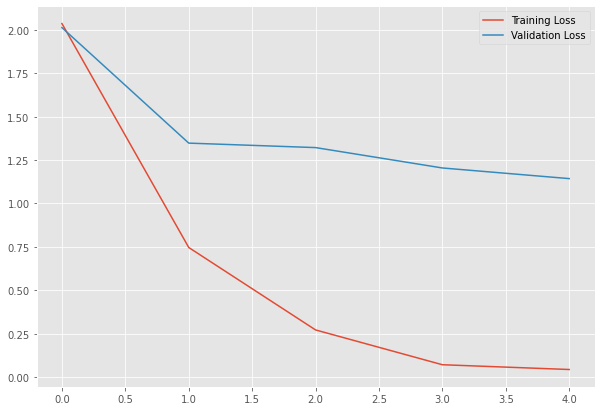

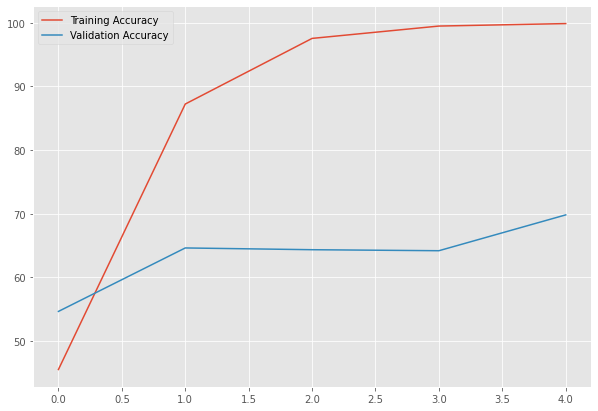

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
val.shape

(104, 14)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val,transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=615)

model.load_state_dict(torch.load('vit-base.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=le.classes_))

                           precision    recall  f1-score   support

          Ancyclostoma sp       0.38      0.30      0.33        20
     Ascaris lumbricoides       0.57      0.73      0.64        45
       Cryptosporidium sp       0.68      0.85      0.76        20
  Cyclospora cayetanensis       0.75      0.80      0.77        45
  Dibothriocephalus latus       0.55      0.44      0.49        25
    Entamoeba histolytica       0.78      0.80      0.79        45
  Enterobius vermicularis       0.85      0.44      0.58        25
       Giardia duodenalis       0.95      0.82      0.88        45
         Hymenolepis nana       0.82      0.45      0.58        20
    Plasmodium falciparum       0.74      0.82      0.78        45
      Plasmodium knowlesi       0.89      0.85      0.87        20
      Plasmodium malariae       0.72      0.93      0.82        45
         Plasmodium ovale       0.62      0.67      0.65        45
         Plasmodium vivax       0.74      0.51      0.61     

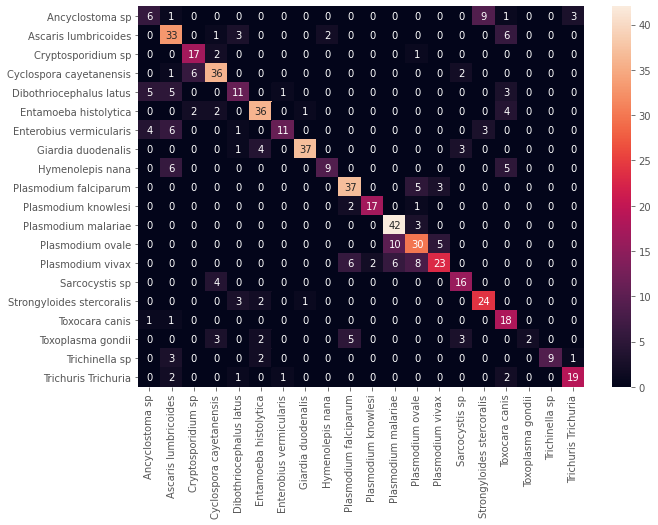

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# VIT Resnet50 Imagenet 21k

In [11]:
class ViResNet50(nn.Module):
  def __init__(self,num_classes_classifier=16):
    super().__init__()
    self.img_transformer = timm.models.vision_transformer.vit_base_resnet50_224_in21k(pretrained=True,num_classes = 0)
    self.fc1 = nn.Linear(768,512)
    self.drop = nn.Dropout(0.4)
    self.norm = nn.BatchNorm1d(512)
    self.classifier = nn.Linear(512,num_classes_classifier)

  def forward(self,img):
    repr = self.img_transformer(img)
    repr = torch.relu(self.fc1(repr))
    repr = self.drop(repr)
    repr = self.norm(repr)
    output = self.classifier(repr)

    return output  

In [12]:
model = ViResNet50()

Removing representation layer for fine-tuning.
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_resnet50_224_in21k-6f7c7740.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_resnet50_224_in21k-6f7c7740.pth


In [ ]:
model.load_state_dict(torch.load('vit-resnet.bin'))

<All keys matched successfully>

In [ ]:
torch.seed()

14185017976319700136

In [15]:
device = torch.device('cuda')
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
es = EarlyStopping(patience = 10)
es.best = np.inf

model.cuda()

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)
    loss.backward()

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps

  # val_losses.append(val_epoch_loss)
  # val_accs.append(val_epoch_acc)
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_loss < es.best:
    best_loss = val_epoch_loss
    print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
    torch.save(model.state_dict(),'vit-resnet.bin')

    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if es.step(torch.tensor(val_epoch_loss)):
    print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
    break
  if val_epoch_loss > best_loss:
    print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')

RuntimeError: ignored

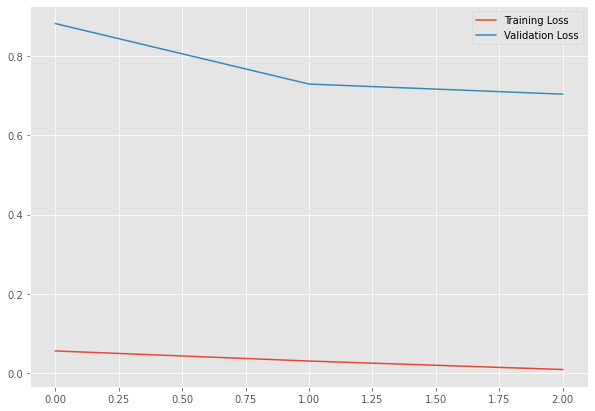

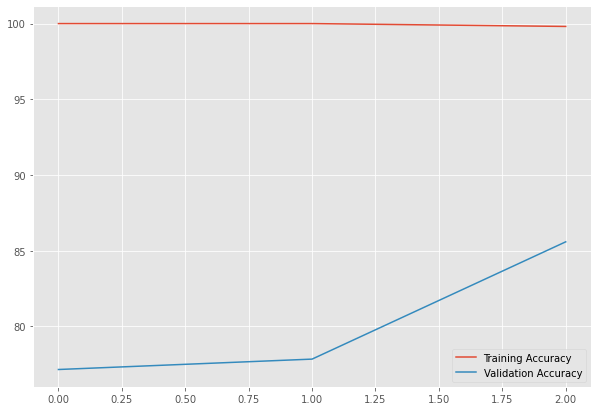

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset('/content/val.csv',transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)
model.load_state_dict(torch.load('vit-resnet.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=val_dataset.LE.classes_))

                           precision    recall  f1-score   support

         Ancyclostoma sp.       1.00      0.50      0.67         2
     Ascaris lumbricoides       1.00      1.00      1.00         4
      Cryptosporidium sp.       1.00      1.00      1.00         2
  Cyclospora cayetanensis       1.00      1.00      1.00         4
  Dibothriocephalus latus       1.00      1.00      1.00         3
   Entamoeba histolytica]       0.80      1.00      0.89         4
  Enterobius vermicularis       0.50      0.50      0.50         2
       Giardia duodenalis       1.00      0.75      0.86         4
    Plasmodium falciparum       1.00      0.80      0.89         5
      Plasmodium malariae       0.60      0.75      0.67         4
         Plasmodium ovale       0.50      1.00      0.67         3
         Plasmodium vivax       1.00      0.60      0.75         5
          Sarcocystis sp.       1.00      1.00      1.00         2
Strongyloides stercoralis       0.50      0.67      0.57     

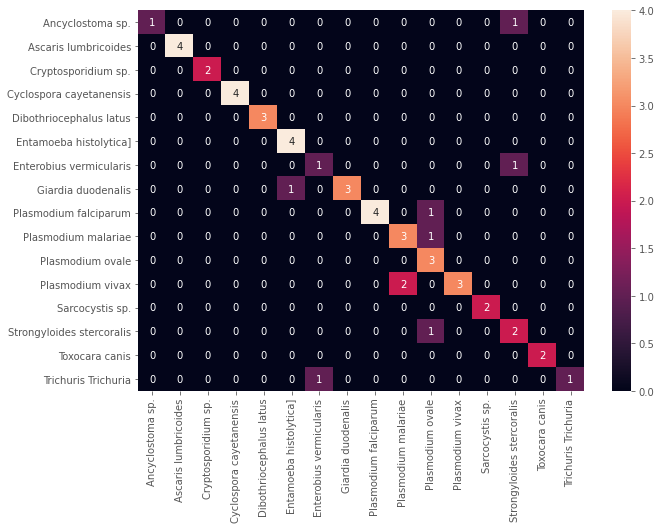

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = val_dataset.LE.classes_,
                  columns = val_dataset.LE.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()